# <center>CSIS 452 - Applied Machine Learning</center>
## Assignment 8 - due: 5/7/2019
In this assignment you will develop a Convolutional Neural Network (CNN) for handwritten digit recognition using MNIST data set.

Enter your name as a comment in the cell below

In [1]:
#Gabe Austin

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score

import keras
from keras import optimizers
from keras import losses
from keras import metrics
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras import backend as K 
from keras.layers.normalization import BatchNormalization
from keras.layers import Dropout
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.layers import Flatten

Using TensorFlow backend.


The following function can be used to display a random sample of images along with targets and predicted class.

In [2]:
def display_a_random_sample_of_images(grid_size, images, targets, predictions=np.array([]), title="images"):
    """ 
    Displayes a random sample of images with the corresponding targets
    
    
    Argument:
        grid_size -- size of subplot will be grid_sizeXgrid_size.
        images -- an array of images 32x32  (num_images x 8 x 8)
        targets -- an array of class values (num_images x 1) containing class values 
             between 0 and 9  
        predictions -- an array of predicted class values (nume_images X 1) containig predicted
             class values between 0 and 9
    Returns:
        None
    """

    class_names = ['0','1','2','3','4','5','6','7','8','9']
    #reshape the images for display
    
    fig, axes1 = plt.subplots(grid_size,grid_size,figsize=(3,3))
    fig.suptitle(title, fontsize="x-small")
    plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.8, hspace=0.8)
    
    for j in range(grid_size):
        for k in range(grid_size):
            i = np.random.choice(range(len(images)))
            axes1[j][k].set_axis_off()
            if predictions.size > 0:
                axes1[j][k].set_title(class_names[targets[i]]+","+class_names[predictions[i]])
            else:
                axes1[j][k].set_title(class_names[targets[i]])
            axes1[j][k].title.set_fontsize(8)
            axes1[j][k].imshow(images[i, :,:], cmap = matplotlib.cm.binary, interpolation="nearest")

Let's first load the data set from keras datasets.  You will need to look at Keras datasets documentation, learn about the MNIST data set and develop the code below.

In [3]:
from keras.datasets import mnist
def load_digits():
    """
    Load and returns images and targets from the sklearn digits dataset.  
    
    Arguments: None
    
    #Returns: 
        images -- an array of digit images (num_imagesX8x8) 
               -- images are in normlaized form
        target_classes -- an array of class values (num_imagesX1) containing 
        class values between 0 and 9

    """    

    (X_train, y_train), (X_test, y_test) = mnist.load_data()
    
    return X_train, y_train, X_test, y_test

Now, let's load the images and display a random sample of 9 images in a 3-by-3 grid along with their corresponding target class using the functions developed above.

(60000, 28, 28, 1) (60000, 1) (10000, 28, 28, 1) (10000, 1)


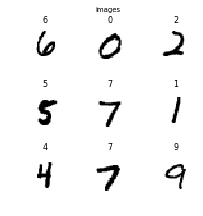

In [4]:
X_train, y_train, X_test, y_test = load_digits()
X_train_reshape = X_train.reshape(-1,28,28,1)
X_test_reshape = X_test.reshape(-1,28,28,1)
y_train_reshape = y_train.reshape(-1,1)
y_test_reshape = y_test.reshape(-1,1)
print(X_train_reshape.shape, y_train_reshape.shape, X_test_reshape.shape, y_test_reshape.shape)
np.random.seed(2)
display_a_random_sample_of_images(3, X_train, y_train, title="images")
plt.show()

## Expected output:
<p>Your plots should be similar to the ones below, but they won't be exact match</P>
<p><img src="Figure1.png" width="40%" height="40%" align="left"> <br></p>


No need to reshape the images, as we will be useing 2-D Convilutional Layers.  We will however still need to use one-hot encoding of the targets.  So, let's take care of that first.

In [5]:
from sklearn.preprocessing import OneHotEncoder
cat_encoder = OneHotEncoder()
y_train_1hot = cat_encoder.fit_transform(y_train_reshape)
y_test_1hot = cat_encoder.fit_transform(y_test_reshape)
print(y_train_1hot.shape)
print(y_test_1hot.shape)

(60000, 10)
(10000, 10)


C:\Users\Gabe\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:368: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)
C:\Users\Gabe\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:368: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used

## Expected output:
(60000, 10)
(10000, 10)

Now, let's build the model and train the it.  Use validation_split of 0.1 to allow for a 10% validation set, 5 epochs for training and set training to be verbos.  Keep in mind that this is a multi-class problem, so your loss should be <b>categorical_crossentropy</b> and for metrics use <b>accuracy</b>.  You will also need to bacth normalize before and use dropout after each maxpooly layer, after the each leyer of the fully connected layers.  The CNN structore should be as shown below

<p><img src="Figure0.png" width="600%" height="60%" align="left"> <br></p>

<p></p>

In [7]:
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.layers import Flatten

K.clear_session()

num_classes = 10
dropout_rate = 0.1
num_epochs = 5

kernel_size_conv = (3,3)
strides_conv = 1
padding_conv = 'same'

kernel_size_max_pool = (2,2)
stride_max_pool = 2

input_layer_shape = X_train_reshape.shape[1:]
print(input_layer_shape)

n_filters_conv_1 = 16
n_filters_conv_2 = 16
n_filters_conv_3 = 32
n_filters_conv_4 = 32
n_filters_conv_5 = 64
n_filters_conv_6 = 64

n_hidden_1_fully_connected = 516
n_hidden_2_fully_connected = 128

n_outputs =  10

model = Sequential() 
model.add(Convolution2D(filters=n_filters_conv_1, 
                        kernel_size = kernel_size_conv,
                        strides= strides_conv, 
                        padding = padding_conv, 
                        input_shape=input_layer_shape))
model.add(Activation('relu'))

model.add(Convolution2D(filters=n_filters_conv_2, 
                        kernel_size = kernel_size_conv,
                        strides= strides_conv, 
                        padding = padding_conv
                       ))
model.add(Activation('relu'))

model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=kernel_size_max_pool, strides=stride_max_pool)) 
model.add(Dropout(dropout_rate))  

model.add(Convolution2D(filters=n_filters_conv_3, 
                        kernel_size = kernel_size_conv,
                        strides= strides_conv, 
                        padding = padding_conv
                        ))
model.add(Activation('relu'))

model.add(Convolution2D(filters=n_filters_conv_4, 
                        kernel_size = kernel_size_conv,
                        strides= strides_conv, 
                        padding = padding_conv 
                        ))
model.add(Activation('relu'))

model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=kernel_size_max_pool, strides=stride_max_pool))
model.add(Dropout(dropout_rate)) 

model.add(Convolution2D(filters=n_filters_conv_5, 
                        kernel_size = kernel_size_conv,
                        strides= strides_conv, 
                        padding = padding_conv 
                        ))
model.add(Activation('relu'))

model.add(Convolution2D(filters=n_filters_conv_6, 
                        kernel_size = kernel_size_conv,
                        strides= strides_conv, 
                        padding = padding_conv 
                        ))
model.add(Activation('relu'))
                
model.add(Flatten())
  
model.add(Dense(n_hidden_1_fully_connected))
model.add(BatchNormalization())
model.add(Dropout(dropout_rate))
model.add(Activation('relu'))
model.add(Dense(n_hidden_2_fully_connected))
model.add(BatchNormalization())
model.add(Dropout(dropout_rate))
model.add(Activation('relu'))
model.add(Dense(n_outputs))
model.add(BatchNormalization())
model.add(Dropout(dropout_rate))
model.add(Activation('softmax'))
      
 
model.compile(loss='categorical_crossentropy', 
    metrics=['accuracy'], optimizer='adadelta')
 
history = model.fit(X_train_reshape, y_train_1hot, epochs = num_epochs, validation_split = 0.1, verbose=1)

(28, 28, 1)
Train on 54000 samples, validate on 6000 samples
Epoch 1/5
54000/54000 [==============================] - 182s 3ms/step - loss: 0.4477 - acc: 0.8787 - val_loss: 0.1134 - val_acc: 0.9782
Epoch 2/5
54000/54000 [==============================] - 178s 3ms/step - loss: 0.2734 - acc: 0.9199 - val_loss: 0.0432 - val_acc: 0.9925
Epoch 3/5
54000/54000 [==============================] - 179s 3ms/step - loss: 0.2186 - acc: 0.9336 - val_loss: 0.0390 - val_acc: 0.9907
Epoch 4/5
54000/54000 [==============================] - 10975s 203ms/step - loss: 0.1934 - acc: 0.9368 - val_loss: 0.0293 - val_acc: 0.9937
Epoch 5/5
24480/54000 [============>.................] - ETA: 50:54:09 - loss: 0.1841 - acc: 0.9400

KeyboardInterrupt: 

Let's plot training curves and see how the model is doing on training and validation.

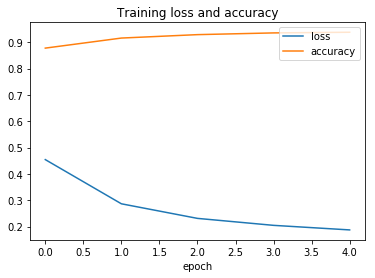

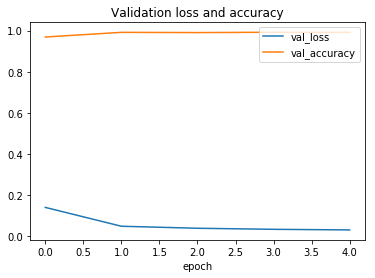

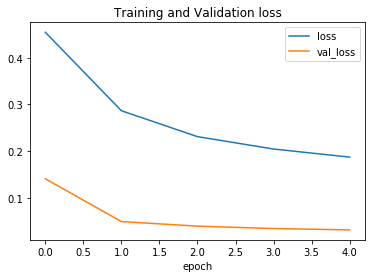

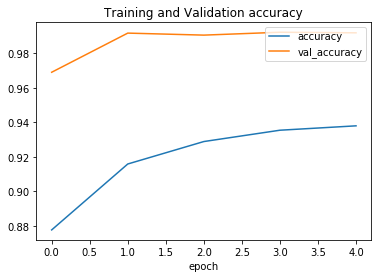

In [25]:
training_fig = plt.figure()
training_ax = training_fig.add_subplot(111)
training_ax.plot(history.history['loss'])
training_ax.plot(history.history['acc'])
training_ax.set_title('Training loss and accuracy')
training_ax.set_xlabel('epoch')
training_ax.legend(['loss', 'accuracy'], loc='upper right')

validation_fig = plt.figure()
validation_ax = validation_fig.add_subplot(111)
validation_ax.plot(history.history['val_loss'])
validation_ax.plot(history.history['val_acc'])
validation_ax.set_title('Validation loss and accuracy')
validation_ax.set_xlabel('epoch')
validation_ax.legend(['val_loss', 'val_accuracy'], loc='upper right')

tarin_val_loss_fig = plt.figure()
tarin_val_loss_ax = tarin_val_loss_fig.add_subplot(111)
tarin_val_loss_ax.plot(history.history['loss'])
tarin_val_loss_ax.plot(history.history['val_loss'])
tarin_val_loss_ax.set_title('Training and Validation loss')
tarin_val_loss_ax.set_xlabel('epoch')
tarin_val_loss_ax.legend(['loss', 'val_loss'], loc='upper right')

tarin_val_loss_fig = plt.figure()
tarin_val_loss_ax = tarin_val_loss_fig.add_subplot(111)
tarin_val_loss_ax.plot(history.history['acc'])
tarin_val_loss_ax.plot(history.history['val_acc'])
tarin_val_loss_ax.set_title('Training and Validation accuracy')
tarin_val_loss_ax.set_xlabel('epoch')
tarin_val_loss_ax.legend(['accuracy', 'val_accuracy'], loc='upper right')

plt.show()

## Expected output:
<p>Your plots should be similar to the ones below, but they won't be exact match</P>
<p><img src="Figure2.png" width="40%" height="40%" align="left"> <br></p>


Now let's evaluate the model on the training and test images.  First, we will need to get the h values.  Keep in mind that the we need to inverse transform the 1hot encoded labels to the original labels.

In [26]:
p_train_1hot = model.predict(X_train_reshape)
h_train_1hot = np.array([elm for elm in p_train_1hot>0.5], dtype=int) #Convert probabilities to class labels)
h_train =  np.squeeze(cat_encoder.inverse_transform(h_train_1hot)) #Retrive original class labels)

p_train_1hot = model.predict(X_test_reshape)
h_test_1hot = np.array([elm for elm in p_train_1hot>0.5], dtype=int) 
h_test =  np.squeeze(cat_encoder.inverse_transform(h_test_1hot)) 

Next, we will measure the model performance on the training set and test set using Confusion Matrix, Average Accuracy, Average Precision, Average Recall and Average F1-Score. 

In [27]:
cf_train = confusion_matrix(y_train, h_train)
ca_train = np.mean(accuracy_score(np.squeeze(y_train), np.squeeze(h_train)))
ps_train = np.mean(precision_score(y_train, h_train, average='weighted')) 
rs_train = np.mean(recall_score(y_train, h_train, average='weighted'))
f1_train = np.mean(f1_score(y_train, h_train, average='weighted'))
print("Training Performance")
print("Average Train Confusion Matrix:\n", cf_train)
print("Average Train Accuracy: {0:0.2%}".format(ca_train))
print("Average Train Precision {0:0.2%}".format(ps_train))
print("Average Train Recall: {0:0.2%}".format(rs_train))
print("Average Train F1: {0:0.2%}".format(f1_train))

cf_test = confusion_matrix(y_test, h_test)
ca_test = accuracy_score(np.squeeze(y_test), np.squeeze(h_test))
ps_test = precision_score(y_test, h_test, average='weighted')
rs_test = recall_score(y_test, h_test, average='weighted')
f1_test = f1_score(y_test, h_test, average='weighted')
print("Training Performance")
print("Average Test Confusion Matrix:\n", cf_test)
print("Average Test Accuracy: {0:0.2%}".format(ca_test))
print("Average Test Precision {0:0.2%}".format(ps_test))
print("Average Test Recall {0:0.2%}".format(rs_test))
print("Average Test F1: {0:0.2%}".format(f1_test))

Training Performance
Average Train Confusion Matrix:
 [[5920    1    0    0    0    0    2    0    0    0]
 [   5 6722    2    0    0    0    0   13    0    0]
 [  17   16 5913    0    1    0    0    9    0    2]
 [  11    0    1 6106    0    2    0    3    2    6]
 [   6    8    0    0 5801    0    2    3    0   22]
 [  35    2    0   11    0 5336   23    1    4    9]
 [  13    8    0    0    3    0 5893    0    1    0]
 [  10    5    7    0    5    0    0 6236    0    2]
 [  93   17    4    5    6    1   15    4 5687   19]
 [  25    2    2    1   25    2    0    9    3 5880]]
Average Train Accuracy: 99.16%
Average Train Precision 99.17%
Average Train Recall: 99.16%
Average Train F1: 99.16%
Training Performance
Average Test Confusion Matrix:
 [[ 977    0    0    0    0    0    2    1    0    0]
 [   0 1134    0    0    0    0    0    1    0    0]
 [   2    0 1027    0    0    0    0    3    0    0]
 [   1    0    0 1008    0    0    0    0    1    0]
 [   3    1    0    0  968    0   

## Expected output:
<p> You performance should be close to the following, it won't be exact.</p>
<p><img src="Figure3.png" width="40%" height="40%" align="left"> <br></p>


Finally, let's examine a set of images and compare their predicted and actual labels.

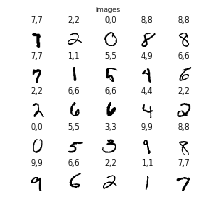

In [28]:
np.random.seed(5)
display_a_random_sample_of_images(grid_size = 5, images= X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[1]), targets=np.squeeze(y_test).astype(int), predictions = np.squeeze(h_test).astype(int) )

## Expected output:
<p> You output should be close to the following, but it won't be exact.</p>
<p><img src="Figure4.png" width="20%" height="20%" align="left"> <br></p>